**Table of contents**<a id='toc0_'></a>    
- [Visualize](#toc1_)    
  - [t-SNE Feature Distribution](#toc1_1_)    
    - [Load functions](#toc1_1_1_)    
    - [A set t-SNE fit](#toc1_1_2_)    
    - [B set t-SNE fit](#toc1_1_3_)    
    - [C set t-SNE fit](#toc1_1_4_)    
  - [Fair Comparison](#toc1_2_)    
    - [Real and Syn](#toc1_2_1_)    
    - [Compare Different Generation EPs](#toc1_2_2_)    
    - [Compare dreaug t-SNE](#toc1_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Visualize](#toc0_)

## <a id='toc1_1_'></a>[t-SNE Feature Distribution](#toc0_)

### <a id='toc1_1_1_'></a>[Load functions](#toc0_)

In [2]:
# Firstly init the model to save time
from mmcls.apis import init_model

CONFIG = "../outputs/res50_fusrs_v2_aug20p_run2/res50_1x128_lr1e-1+200e+im21k_fusrs_v2+ctrlcam/res50_1x128_lr1e-1+200e+im21k_fusrs_v2+ctrlcam.py"
CKPT = "../outputs/res50_fusrs_v2_aug20p_run2/res50_1x128_lr1e-1+200e+im21k_fusrs_v2+ctrlcam_ep20/top10_f1_score_epoch_162.pth"
DEVICES = "cuda:0"
model = init_model(CONFIG, CKPT, device=DEVICES)

/opt/conda/envs/mmcls/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: ../outputs/res50_fusrs_v2_aug20p_run2/res50_1x128_lr1e-1+200e+im21k_fusrs_v2+ctrlcam_ep20/top10_f1_score_epoch_162.pth


In [3]:
# Fit Single train list
import numpy as np
import matplotlib.pyplot as plt
import mmcv
import os
from PIL import Image
import torch
from tqdm.notebook import tqdm
import random

# from sklearn.manifold import TSNE


class_mapping = {
    "0": "Cargo",
    "1": "Other",
    "2": "Fishing",
    "3": "Tanker",
    "4": "Dredger",
}


def load_annotations(file_path, data_root, n=None):
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Randomly select the desired proportion of samples
    if n is not None:
        if n < len(lines):
            selected_lines = random.sample(lines, n)
        else:
            print(
                f"WARNING: The n={n} is larger than the number of samples {len(lines)}. Use n={len(lines)} instead."
            )
    else:
        selected_lines = lines

    X_image_paths = []
    Y_categories = []

    for line in selected_lines:
        image_path, category_index = line.strip().split(" ")
        X_image_paths.append(os.path.join(data_root, image_path))
        Y_categories.append(int(category_index))

    return X_image_paths, Y_categories


def extract_features(model, img_path):
    # Load and preprocess image
    img = Image.open(img_path)
    img = img.convert("RGB")
    img = np.array(img).astype("float32")
    img = mmcv.imnormalize(
        img,
        mean=np.array([11.20954390854399, 11.20954390854399, 11.20954390854399]),
        std=np.array([20.241805767392393, 20.241805767392393, 20.241805767392393]),
        to_rgb=True,
    )

    # Pad and transpose
    img = mmcv.impad_to_multiple(img, divisor=32)
    if len(img.shape) == 2:
        img = img[..., None]
    img = img.transpose(2, 0, 1)

    # Inference and extract features
    with torch.no_grad():
        img_tensor = torch.from_numpy(img).to(DEVICES).unsqueeze(0)
        model_output = model.extract_feat(img_tensor)[0]
        features = model_output.squeeze().cpu().numpy()

    return features

### <a id='toc1_1_2_'></a>[A set t-SNE fit](#toc0_)

In [3]:
# Assuming you have two sets of sample images with their respective labels:
# image_paths_1, categories_1, image_paths_2, categories_2

ANN_1 = "../data/fusrs_v2/meta/train.txt"
DATA_ROOT_1 = "../data/fusrs_v2/"

# Extract features and labels for ANN_1
image_paths_1, categories_1 = load_annotations(ANN_1, DATA_ROOT_1, n=1000)
y1 = np.array(categories_1)
X1 = []
y_labels_1 = [class_mapping[str(label)] for label in y1]
for img_path in tqdm(image_paths_1, desc="Extracting features for Set 1"):
    features = extract_features(model, img_path)
    X1.append(features)
X1 = np.array(X1)

Extracting features for Set 1:   0%|          | 0/1000 [00:00<?, ?it/s]

### <a id='toc1_1_3_'></a>[B set t-SNE fit](#toc0_)

In [4]:
ANN_2 = "../data/fusrs_v2/meta/val.txt"
DATA_ROOT_2 = "../data/fusrs_v2/"
# Extract features and labels for ANN_2
image_paths_2, categories_2 = load_annotations(ANN_2, DATA_ROOT_2, n=1000)
y2 = np.array(categories_2)
X2 = []
y_labels_2 = [class_mapping[str(label)] for label in y2]
for img_path in tqdm(image_paths_2, desc="Extracting features for Set 2"):
    features = extract_features(model, img_path)
    X2.append(features)
X2 = np.array(X2)

Extracting features for Set 2:   0%|          | 0/869 [00:00<?, ?it/s]

### <a id='toc1_1_4_'></a>[C set t-SNE fit](#toc0_)

In [5]:
ANN_3 = "../data/fusrs_v2/meta/run0_v1/ctrl+cam/syn_2+3+4.txt"
DATA_ROOT_3 = "../data/fusrs_v2/"
# Extract features and labels for ANN_3
image_paths_3, categories_3 = load_annotations(ANN_3, DATA_ROOT_3, n=1000)
y3 = np.array(categories_3)
X3 = []
y_labels_3 = [class_mapping[str(label)] for label in y3]
for img_path in tqdm(image_paths_3, desc="Extracting features for Set 2"):
    features = extract_features(model, img_path)
    X3.append(features)
X3 = np.array(X3)

Extracting features for Set 2:   0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
# from openTSNE import TSNE
from MulticoreTSNE import MulticoreTSNE

tsne = MulticoreTSNE(
    n_components=2,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    perplexity=50,
    # learning_rate=200,
)
X_embedded_1 = tsne.fit_transform(X1)
X_embedded_2 = tsne.fit_transform(X2)
X_embedded_3 = tsne.fit_transform(X3)

Performing t-SNE using 80 cores.
Using no_dims = 2, perplexity = 50.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 102 of 1000
 - point 201 of 1000
 - point 300 of 1000
 - point 400 of 1000
 - point 500 of 1000
 - point 600 of 1000
 - point 700 of 1000
 - point 800 of 1000
 - point 900 of 1000
 - point 1000 of 1000
Done in 1.00 seconds (sparsity = 0.230947)!
Learning embedding...
Iteration 51: error is 61.120514 (50 iterations in 0.00 seconds)
Iteration 101: error is 61.077002 (50 iterations in 0.00 seconds)
Iteration 151: error is 61.072170 (50 iterations in 1.00 seconds)
Iteration 201: error is 61.093534 (50 iterations in 0.00 seconds)
Iteration 251: error is 61.073580 (50 iterations in 1.00 seconds)
Iteration 301: error is 0.944080 (50 iterations in 0.00 seconds)
Iteration 351: error is 0.792889 (50 iterations in 1.00 seconds)
Iteration 401: error is 0.743938 (50 iterations in 1.00 seconds)
Iteration 451: error is 0.723976 (50 iterations in 0.

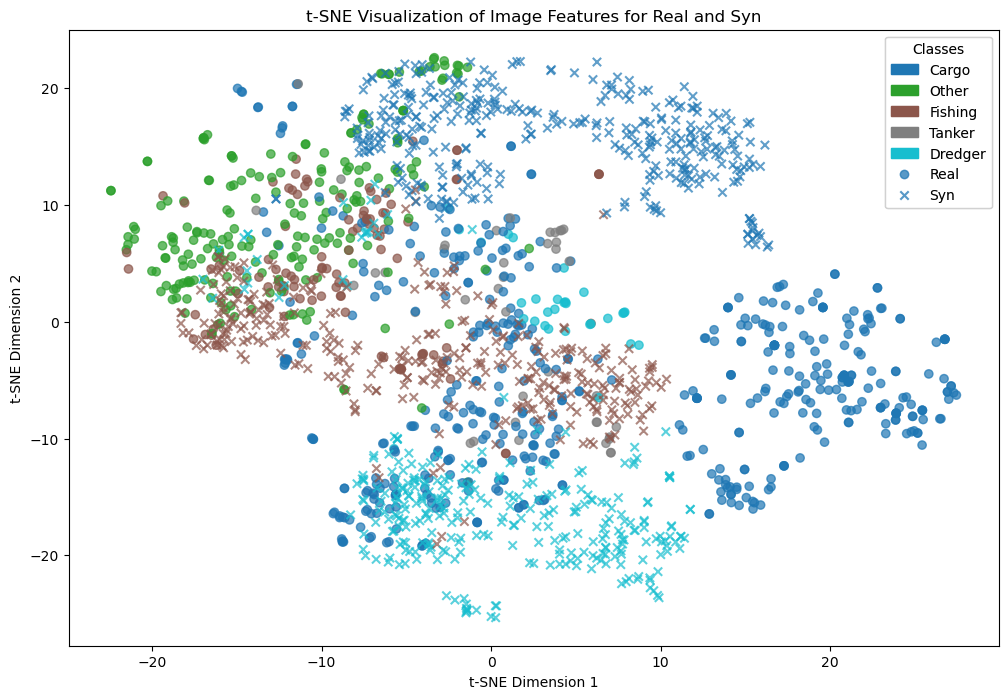

In [23]:
# Visualize t-SNE output
import matplotlib.patches as mpatches

# Plot the t-SNE embeddings of both sets on the same plot
plt.figure(figsize=(12, 8))
# scatter1 = plt.scatter(
#     X_embedded_1[:, 0],
#     X_embedded_1[:, 1],
#     c=y1,
#     cmap="tab10",
#     # cmap="Blues",
#     alpha=0.7,
#     marker="o",
#     label="Train",
# )
scatter2 = plt.scatter(
    X_embedded_2[:, 0],
    X_embedded_2[:, 1],
    c=y2,
    cmap="tab10",
    # cmap="Oranges",
    alpha=0.7,
    marker="o",
    label="Real",
)
scatter3 = plt.scatter(
    X_embedded_3[:, 0],
    X_embedded_3[:, 1],
    c=y3,
    cmap="tab10",
    # cmap="Greens",
    alpha=0.7,
    marker="x",
    label="Syn",
)
plt.title("t-SNE Visualization of Image Features for Real and Syn")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Create custom legend handles and labels
legend_labels = list(class_mapping.values())

handles = [
    mpatches.Patch(color=plt.cm.tab10(i / (len(legend_labels) - 1)), label=label)
    for i, label in enumerate(legend_labels)
]

handles.extend(
    [
        # scatter1.legend_elements()[0][0],
        scatter2.legend_elements()[0][0],
        scatter3.legend_elements()[0][0],
    ]
)

labels = legend_labels + ["Real", "Syn"]

legend = plt.legend(handles=handles, title="Classes", labels=labels)
plt.gca().add_artist(legend)

plt.show()

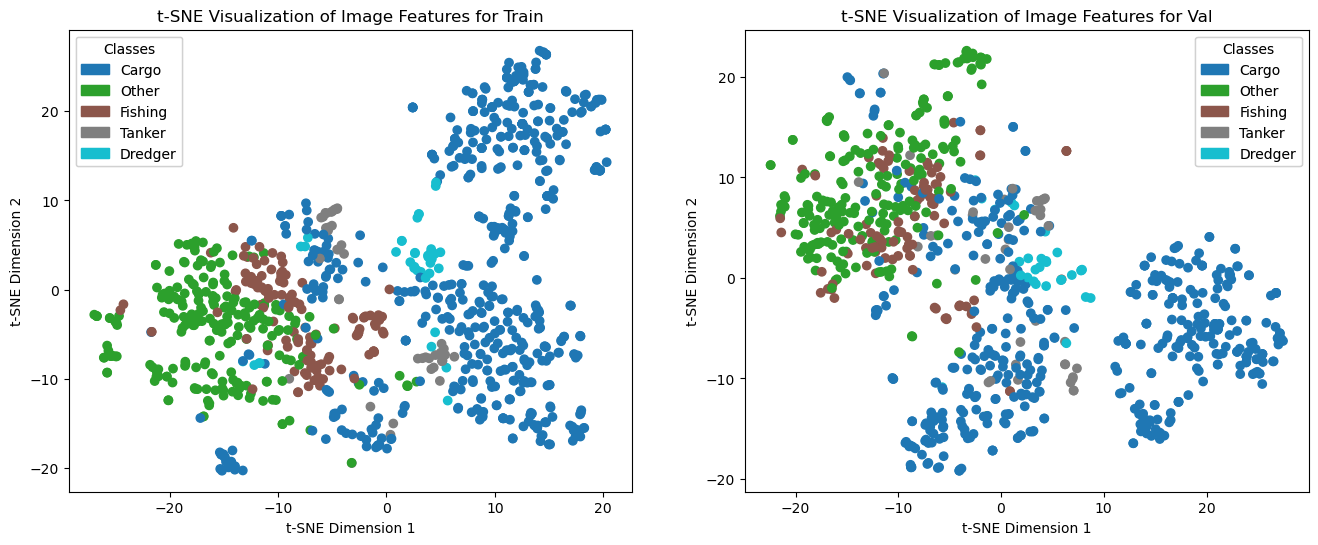

In [31]:
import matplotlib.patches as mpatches

# Create a figure for the subplots
fig = plt.figure(figsize=(16, 6))

# Subplot for the Train set
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot

scatter1 = plt.scatter(
    X_embedded_1[:, 0],
    X_embedded_1[:, 1],
    c=y1,
    cmap="tab10",
    alpha=1,
    marker="o",
    label="Train",
)

plt.title("t-SNE Visualization of Image Features for Train")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Subplot for the Val set
ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot

scatter2 = plt.scatter(
    X_embedded_2[:, 0],
    X_embedded_2[:, 1],
    c=y2,
    cmap="tab10",
    alpha=1,
    marker="o",
    label="Val",
)

plt.title("t-SNE Visualization of Image Features for Val")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Create custom legend handles and labels
legend_labels = list(class_mapping.values())

handles = [
    mpatches.Patch(color=plt.cm.tab10(i / (len(legend_labels) - 1)), label=label)
    for i, label in enumerate(legend_labels)
]

# Add a legend for each subplot
for ax, scatter, label in zip([ax1, ax2], [scatter1, scatter2], ["Train", "Val"]):
    handles_ext = [scatter.legend_elements()[0][0]]
    labels_ext = []
    legend = ax.legend(
        handles=handles + handles_ext,
        title="Classes",
        labels=legend_labels + labels_ext,
    )
    ax.add_artist(legend)

plt.show()

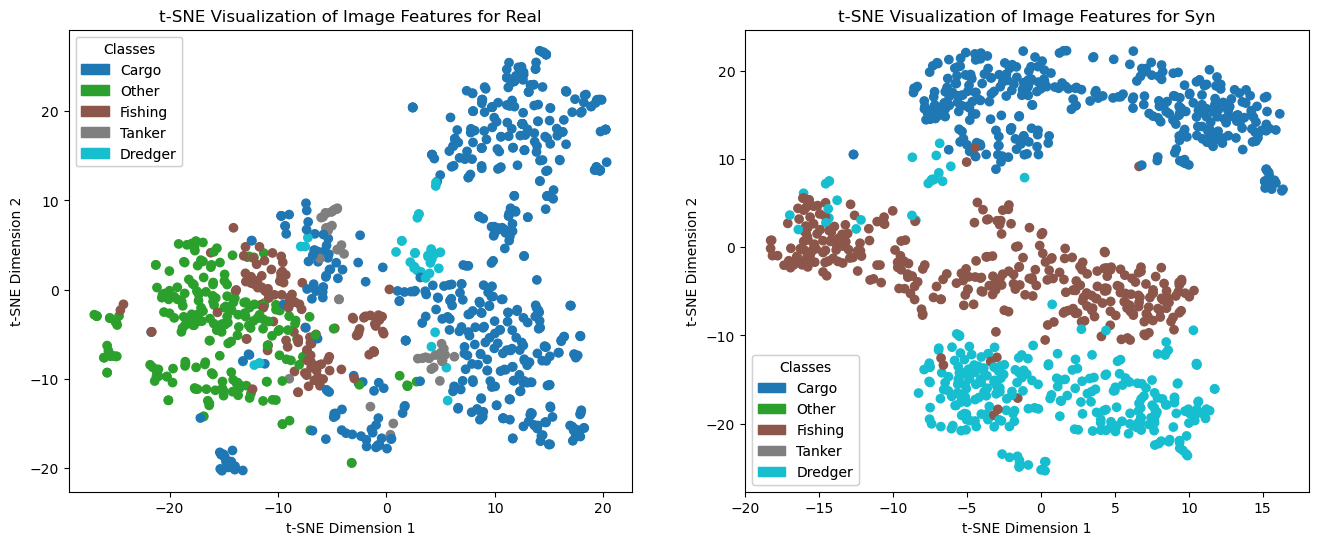

In [30]:
import matplotlib.patches as mpatches

# Create a figure for the subplots
fig = plt.figure(figsize=(16, 6))

# Subplot for the real set
ax1 = plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot

scatter1 = plt.scatter(
    X_embedded_1[:, 0],
    X_embedded_1[:, 1],
    c=y1,
    cmap="tab10",
    alpha=1,
    marker="o",
    label="Real",
)

plt.title("t-SNE Visualization of Image Features for Real")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Subplot for the synthetic set
ax2 = plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot

scatter2 = plt.scatter(
    X_embedded_3[:, 0],
    X_embedded_3[:, 1],
    c=y3,
    cmap="tab10",
    alpha=1,
    marker="o",
    label="Syn",
)

plt.title("t-SNE Visualization of Image Features for Syn")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Create custom legend handles and labels
legend_labels = list(class_mapping.values())

handles = [
    mpatches.Patch(color=plt.cm.tab10(i / (len(legend_labels) - 1)), label=label)
    for i, label in enumerate(legend_labels)
]

# Add a legend for each subplot
for ax, scatter, label in zip([ax1, ax2], [scatter1, scatter2], ["Real", "Syn"]):
    handles_ext = [scatter.legend_elements()[0][0]]
    labels_ext = []
    legend = ax.legend(
        handles=handles + handles_ext,
        title="Classes",
        labels=legend_labels + labels_ext,
    )
    ax.add_artist(legend)

plt.show()

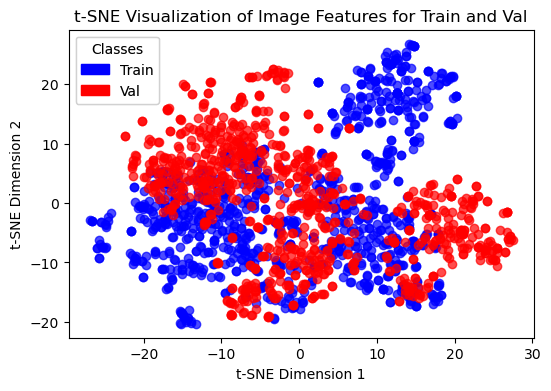

In [15]:
# Visualize t-SNE output
import matplotlib.patches as mpatches

# Plot the t-SNE embeddings of both sets on the same plot
plt.figure(figsize=(6, 4))
scatter1 = plt.scatter(
    X_embedded_1[:, 0],
    X_embedded_1[:, 1],
    c="blue",  # Single color for train set
    alpha=0.7,
    marker="o",
    label="Train",
)
scatter2 = plt.scatter(
    X_embedded_2[:, 0],
    X_embedded_2[:, 1],
    c="red",  # Single color for synthetic set
    alpha=0.7,
    marker="o",
    label="Val",
)
# scatter3 = plt.scatter(
#     X_embedded_3[:, 0],
#     X_embedded_3[:, 1],
#     c="red",  # Single color for synthetic set
#     alpha=0.7,
#     marker="o",
#     label="Syn",
# )
plt.title("t-SNE Visualization of Image Features for Train and Val")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Create custom legend handles and labels
handles = [
    mpatches.Patch(color="blue", label="Train"),
    mpatches.Patch(color="red", label="Val"),
]

legend = plt.legend(handles=handles, title="Classes", labels=["Train", "Val"])
plt.gca().add_artist(legend)

plt.show()

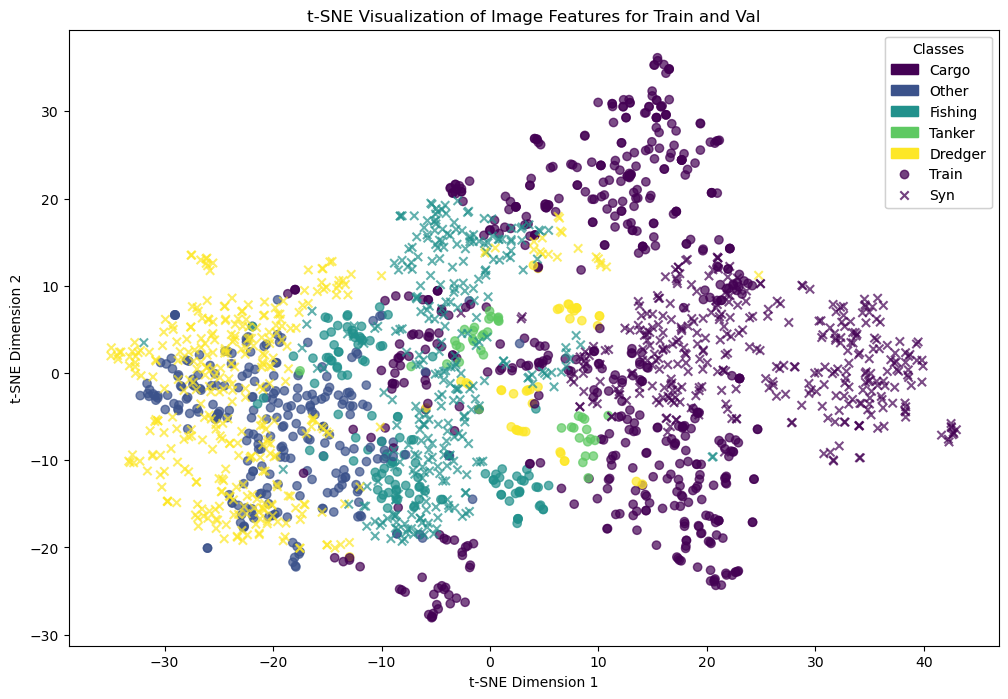

In [34]:
# Visualize t-SNE output
import matplotlib.patches as mpatches

# Plot the t-SNE embeddings of both sets on the same plot
plt.figure(figsize=(12, 8))
scatter1 = plt.scatter(
    X_embedded_1[:, 0],
    X_embedded_1[:, 1],
    c=y1,
    cmap="viridis",
    # cmap="Blues",
    alpha=0.7,
    marker="o",
    label="Train",
)
# scatter2 = plt.scatter(
#     X_embedded_2[:, 0],
#     X_embedded_2[:, 1],
#     c=y2,
#     cmap="viridis",
#     # cmap="Oranges",
#     alpha=0.7,
#     marker="o",
#     label="Val",
# )
scatter3 = plt.scatter(
    X_embedded_3[:, 0],
    X_embedded_3[:, 1],
    c=y3,
    cmap="viridis",
    # cmap="Greens",
    alpha=0.7,
    marker="x",
    label="Syn",
)
plt.title("t-SNE Visualization of Image Features for Train and Val")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Create custom legend handles and labels
legend_labels = list(class_mapping.values())

handles = [
    mpatches.Patch(color=plt.cm.viridis(i / (len(legend_labels) - 1)), label=label)
    for i, label in enumerate(legend_labels)
]

handles.extend(
    [
        scatter1.legend_elements()[0][0],
        # scatter2.legend_elements()[0][0],
        scatter3.legend_elements()[0][0],
    ]
)

# labels = legend_labels + ["Train", "Val", "Syn"]
labels = legend_labels + ["Train", "Syn"]
# labels = legend_labels + ["Train", "Val"]

legend = plt.legend(handles=handles, title="Classes", labels=labels)
plt.gca().add_artist(legend)

plt.show()

## <a id='toc1_2_'></a>[Fair Comparison](#toc0_)

### <a id='toc1_2_1_'></a>[Real and Syn](#toc0_)

In [16]:
# Assuming you have a set of sample images with their respective labels
# X - NumPy array of shape (num_samples, num_features), where each row represents a feature vector for a specific image
# y - NumPy array of shape (num_samples,), where each entry is the label for the corresponding image in X

# ANN_F = "../data/fusrs_v2/meta/run0_v1/ctrl+cam/comp_tr_val_syn_ep20.txt"
ANN_F = "../data/fusrs_v2/meta/run0_v0/ctrl+cam/comp_real_syn_dre_fishing_aug758.txt"
DATA_ROOT = "../data/fusrs_v2/"
image_paths, categories = load_annotations(ANN_F, DATA_ROOT)
# Your MMClassification model label extraction code here
y = np.array(categories)
# Convert integer class labels to category names
y_labels = [class_mapping[str(label)] for label in y]

# Your MMClassification model feature extraction code here
X = []
for img_path in tqdm(image_paths, desc="Extracting features"):
    features = extract_features(model, img_path)
    X.append(features)
X = np.array(X)

Extracting features:   0%|          | 0/2628 [00:00<?, ?it/s]

In [19]:
# from openTSNE import TSNE
from MulticoreTSNE import MulticoreTSNE

tsne = MulticoreTSNE(
    n_components=2,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    perplexity=15,
    n_iter=500,
    # learning_rate=200,
)
X_embedded = tsne.fit_transform(X)

Performing t-SNE using 80 cores.
Using no_dims = 2, perplexity = 15.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 264 of 2628
 - point 524 of 2628
 - point 786 of 2628
 - point 1048 of 2628
 - point 1310 of 2628
 - point 1572 of 2628
 - point 1834 of 2628
 - point 2096 of 2628
 - point 2359 of 2628
 - point 2620 of 2628
Done in 0.00 seconds (sparsity = 0.024474)!
Learning embedding...
Iteration 51: error is 75.794037 (50 iterations in 1.00 seconds)
Iteration 101: error is 72.207115 (50 iterations in 1.00 seconds)
Iteration 151: error is 71.176511 (50 iterations in 0.00 seconds)
Iteration 201: error is 70.588898 (50 iterations in 1.00 seconds)
Iteration 251: error is 70.239550 (50 iterations in 1.00 seconds)
Iteration 301: error is 2.098182 (50 iterations in 1.00 seconds)
Iteration 351: error is 1.672555 (50 iterations in 0.00 seconds)
Iteration 401: error is 1.471417 (50 iterations in 1.00 seconds)
Iteration 451: error is 1.362266 (50 iterations

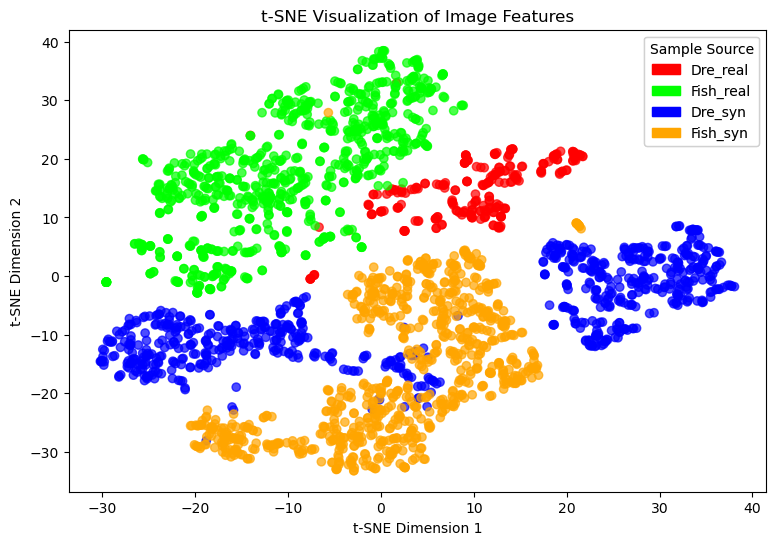

In [20]:
# Visualize t-SNE output
import matplotlib.patches as mpatches

from matplotlib.colors import ListedColormap

# Create a custom colormap with blue, red, and green
custom_cmap = ListedColormap(["red", "lime", "blue", "orange"])

plt.figure(figsize=(9, 6))
scatter = plt.scatter(
    X_embedded[:, 0], X_embedded[:, 1], c=y, cmap=custom_cmap, alpha=0.7, marker="o"
)
plt.title("t-SNE Visualization of Image Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add a legend (if labels have names)
# Get the unique category names
legend_labels = ["Dre_real", "Fish_real", "Dre_syn", "Fish_syn"]

# Create custom legend handles and labels
handles = [
    # mpatches.Patch(color=plt.cm.bwr(i / (len(legend_labels) - 1)), label=label)
    mpatches.Patch(color=custom_cmap(i / (len(legend_labels) - 1)), label=label)
    for i, label in enumerate(legend_labels)
]

# Add a legend
legend = plt.legend(handles=handles, title="Sample Source")
plt.gca().add_artist(legend)

plt.show()

### <a id='toc1_2_2_'></a>[Compare Different Generation EPs](#toc0_)

In [7]:
# Assuming you have a set of sample images with their respective labels
# X - NumPy array of shape (num_samples, num_features), where each row represents a feature vector for a specific image
# y - NumPy array of shape (num_samples,), where each entry is the label for the corresponding image in X

ANN_F = "../data/fusrs_v2/meta/run0_v1/ctrl+cam/comp_tr_syn_ep20_80.txt"
DATA_ROOT = "../data/fusrs_v2/"
image_paths, categories = load_annotations(ANN_F, DATA_ROOT, n=4000)
# Your MMClassification model label extraction code here
y = np.array(categories)
# Convert integer class labels to category names
y_labels = [class_mapping[str(label)] for label in y]

# Your MMClassification model feature extraction code here
X = []
for img_path in tqdm(image_paths, desc="Extracting features"):
    features = extract_features(model, img_path)
    X.append(features)
X = np.array(X)

Extracting features:   0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
# from openTSNE import TSNE
from MulticoreTSNE import MulticoreTSNE

tsne = MulticoreTSNE(
    n_components=2,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    perplexity=50,
    # learning_rate=200,
)
X_embedded = tsne.fit_transform(X)

Performing t-SNE using 80 cores.
Using no_dims = 2, perplexity = 50.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 402 of 4000
 - point 800 of 4000
 - point 1200 of 4000
 - point 1600 of 4000
 - point 2000 of 4000
 - point 2401 of 4000
 - point 2801 of 4000
 - point 3200 of 4000
 - point 3600 of 4000
 - point 4000 of 4000
Done in 1.00 seconds (sparsity = 0.053667)!
Learning embedding...
Iteration 51: error is 72.349577 (50 iterations in 1.00 seconds)
Iteration 101: error is 71.328900 (50 iterations in 1.00 seconds)
Iteration 151: error is 71.308440 (50 iterations in 2.00 seconds)
Iteration 201: error is 71.308454 (50 iterations in 1.00 seconds)
Iteration 251: error is 71.309984 (50 iterations in 1.00 seconds)
Iteration 301: error is 1.818592 (50 iterations in 1.00 seconds)
Iteration 351: error is 1.523091 (50 iterations in 1.00 seconds)
Iteration 401: error is 1.389615 (50 iterations in 2.00 seconds)
Iteration 451: error is 1.315364 (50 iteration

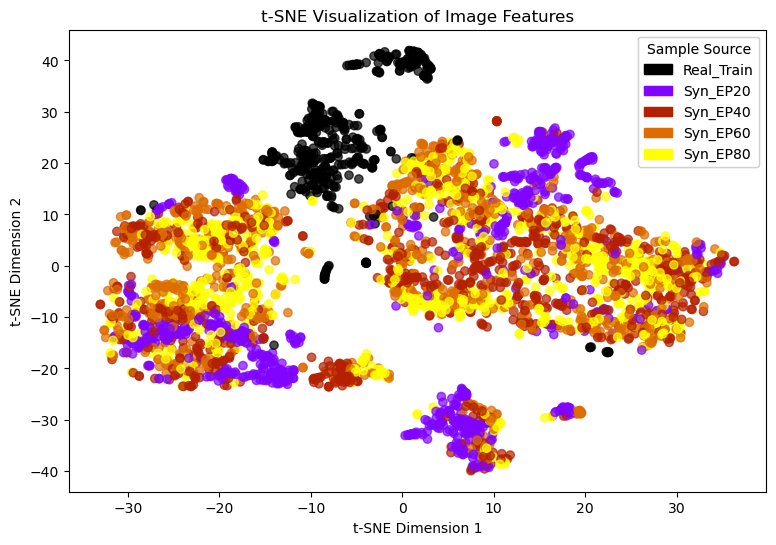

In [21]:
# Visualize t-SNE output
import matplotlib.patches as mpatches

from matplotlib.colors import ListedColormap

plt.figure(figsize=(9, 6))
scatter = plt.scatter(
    X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="gnuplot", alpha=0.7, marker="o"
)
plt.title("t-SNE Visualization of Image Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Add a legend (if labels have names)
# Get the unique category names
legend_labels = ["Real_Train", "Syn_EP20", "Syn_EP40", "Syn_EP60", "Syn_EP80"]

# Create custom legend handles and labels
handles = [
    mpatches.Patch(color=plt.cm.gnuplot(i / (len(legend_labels) - 1)), label=label)
    # mpatches.Patch(color=custom_cmap(i / (len(legend_labels) - 1)), label=label)
    for i, label in enumerate(legend_labels)
]

# Add a legend
legend = plt.legend(handles=handles, title="Sample Source")
plt.gca().add_artist(legend)

plt.show()

### <a id='toc1_2_3_'></a>[Compare dreaug t-SNE](#toc0_)

In [30]:
# Uniform sample functions
import os
import random
from collections import defaultdict

# Assuming you have a set of sample images with their respective labels
# X - NumPy array of shape (num_samples, num_features), where each row represents a feature vector for a specific image
# y - NumPy array of shape (num_samples,), where each entry is the label for the corresponding image in X

class_mapping = {
    "0": "Cargo",
    "1": "Other",
    "2": "Fishing",
    "3": "Tanker",
    "4": "Dredger_train",
    "5": "Dredger_val",
    "6": "Dredger_syn",
}


def uniform_sample(file_path, data_root, n=None):
    with open(file_path, "r") as f:
        lines = f.readlines()

    # Organize the data by categories
    categories = defaultdict(list)
    for line in lines:
        image_path, category_index = line.strip().split(" ")
        categories[int(category_index)].append(os.path.join(data_root, image_path))

    X_image_paths = []
    Y_categories = []

    # Randomly select the desired proportion of samples from each category
    for category_index, category_image_paths in categories.items():
        if n is not None:
            if n < len(category_image_paths):
                selected_image_paths = random.sample(category_image_paths, n)
            else:
                print(
                    f"WARNING: The n={n} is larger than the number of samples {len(category_image_paths)} in category {category_index}. Using n={len(category_image_paths)} instead."
                )
                selected_image_paths = category_image_paths
        else:
            selected_image_paths = category_image_paths

        X_image_paths.extend(selected_image_paths)
        Y_categories.extend([category_index] * len(selected_image_paths))

    return X_image_paths, Y_categories


ANN_F = "../data/fusrs_v2/meta/run0_v0/ctrl+cam/comp_real_syn_dreaug758.txt"
DATA_ROOT = "../data/fusrs_v2/"
image_paths, categories = uniform_sample(ANN_F, DATA_ROOT, n=300)
# Your MMClassification model label extraction code here
y = np.array(categories)
# Convert integer class labels to category names
y_labels = [class_mapping[str(label)] for label in y]

# Your MMClassification model feature extraction code here
X = []
for img_path in tqdm(image_paths, desc="Extracting features"):
    features = extract_features(model, img_path)
    X.append(features)
X = np.array(X)

Extracting features:   0%|          | 0/1772 [00:00<?, ?it/s]

In [31]:
# from openTSNE import TSNE
from MulticoreTSNE import MulticoreTSNE

tsne = MulticoreTSNE(
    n_components=2,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    perplexity=50,
    # learning_rate=200,
)
X_embedded = tsne.fit_transform(X)

Performing t-SNE using 80 cores.
Using no_dims = 2, perplexity = 50.000000, and theta = 0.500000
Computing input similarities...
Building tree...
 - point 177 of 1772
 - point 354 of 1772
 - point 531 of 1772
 - point 708 of 1772
 - point 885 of 1772
 - point 1062 of 1772
 - point 1239 of 1772
 - point 1416 of 1772
 - point 1593 of 1772
 - point 1770 of 1772
Done in 0.00 seconds (sparsity = 0.124913)!
Learning embedding...
Iteration 51: error is 66.635178 (50 iterations in 0.00 seconds)
Iteration 101: error is 66.291877 (50 iterations in 1.00 seconds)
Iteration 151: error is 66.293202 (50 iterations in 0.00 seconds)
Iteration 201: error is 66.247353 (50 iterations in 0.00 seconds)
Iteration 251: error is 66.283164 (50 iterations in 1.00 seconds)
Iteration 301: error is 1.203820 (50 iterations in 1.00 seconds)
Iteration 351: error is 0.966471 (50 iterations in 0.00 seconds)
Iteration 401: error is 0.882759 (50 iterations in 1.00 seconds)
Iteration 451: error is 0.846110 (50 iterations i

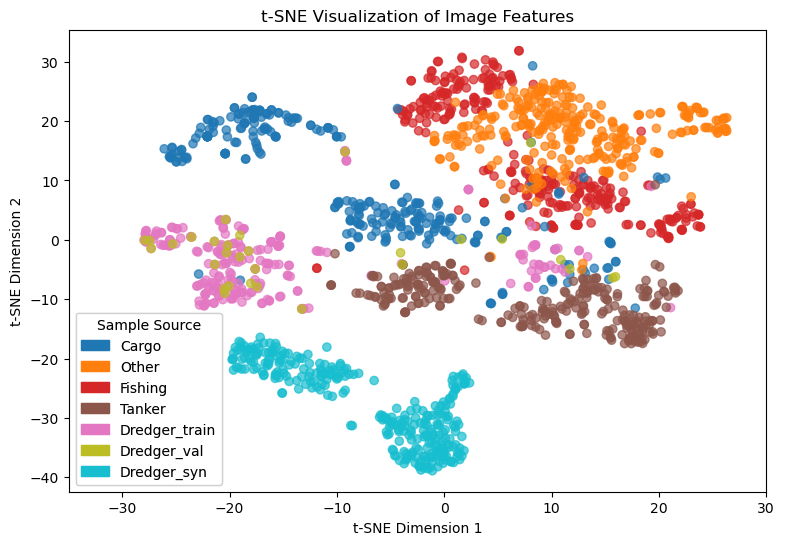

In [35]:
# Visualize t-SNE output
import matplotlib.patches as mpatches

from matplotlib.colors import ListedColormap

plt.figure(figsize=(9, 6))
scatter = plt.scatter(
    X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="tab10", alpha=0.7, marker="o"
)
plt.title("t-SNE Visualization of Image Features")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.xlim(-35, 30)

# Add a legend (if labels have names)
# Get the unique category names
legend_labels = [i for i in class_mapping.values()]

# Create custom legend handles and labels
handles = [
    mpatches.Patch(color=plt.cm.tab10(i / (len(legend_labels) - 1)), label=label)
    # mpatches.Patch(color=custom_cmap(i / (len(legend_labels) - 1)), label=label)
    for i, label in enumerate(legend_labels)
]

# Add a legend
legend = plt.legend(handles=handles, title="Sample Source")
plt.gca().add_artist(legend)

plt.show()